## Julia as a Glue Language

Julia is a great language for scientific and technical programming.
It is more or all I use in my research code these days.
It gets a lot of attention for being great for scientific programming because of its:
great matrix syntax, high speed and optimisability, foreign function interfaces, range of scientific libraries, etc etc.
It has all that sure. (Though it is still in alpha, so many things are a bit broken at times.)
One things that is under-mentioned is how great it is as a "glue" language. <!--more-->  
([Randy Zwitch](http://randyzwitch.com/julia-odbc-jl/) did also blog about this in 2014, though but I feel it is time for another.).

Julia (also) works great as a scripting language to glue together commandline programs.
Taking output from one and giving it as input to the next, with a little processing in between.
Often one would use `bash` for this -- there is a long tradition of such.
Many scientific/technial programs have been made this way.
For example Kaldi for speech recognition research and OpenFST for finite state transducers (the focus of this demo).
I've been told that some bioinformatics workflows involve piping things between TopHat, Bowtie, Cufflinks and CummeRbund.
Whether we like this style of tooling, or not, it is probably going to be around forever;
and if it is a choice between linking to a poorly documented C++ API, or the commandline interface that has a dozen tuitorials I'll thake the commend-line every time.
So we need to glue these programs together, into our scientific workflow; as I mentioned before bash is a common tool of choice for this.

However Bash is not a nice language to program in, particularly if you need to do some custom code between steps.
So one might use `python` for this, but the python syntax for dealing with calling command line programs is kind of arcane.
I personally need to [read the docs](https://docs.python.org/3.6/library/subprocess.html) everything I use it, and dealing with (double or even triple) escaping strings, is a drag. [Plumbum](https://plumbum.readthedocs.io/en/latest/) is a nice python library for dealing with the need for good glue. But it is a 3rd party library, and in anycase today we are talking about julia.

Julia's commandline running stuff is fairly simple. Take a look at [the documentation](http://docs.julialang.org/en/release-0.5/manual/running-external-programs/)
Commands go inside backticks, `` `command arg1 arg2` ``, this is basically a special type of string.
You can iterpolate into it with `command $juliavar`, and it handles all the escaping in an intuitive way.
You can run the commands using `` run(`command arg1 arg2`) ``.
You can run it and read its output into a variable by `myvar = readstring(`command arg1 arg2`)`.
You can pipe serveral commands together with `` pipeline(`command1`, `command2`) `` which can then by `run` or `readstring`'ed.
When the process returns a failure error code, julia throws an exception.
It is all very nice, and easy and that is all you will most of the time.
You can, of course, do more advances stuff, but we won't go into that.


This post focuses on [OpenFST](http://www.openfst.org/).
I wrote an [introduction to OpenFST](http://white.ucc.asn.au/Kaldi-Notes/fst-example/) a few years back, as part of some notes on Kaldi.
If your are not familar with OpenFST, you might like to skim through that first before reading this.
The basic deal is that it is a tool for [Finite State Transducers](https://en.wikipedia.org/wiki/Finite-state_transducer).
Like in those notes some of the examples are borrowed from [Mark Hasegawa-Johnson's 2009 lecture notes](http://www.isle.illinois.edu/sst/courses/minicourses/2009/lecture6.pdf).

The only library I am using is julia's incuded testing library.
As well I am using OpenFST (of course), and graphviz (`dot`) to draw the diagrams.
I worked on this as a [IJulia notebook](https://github.com/JuliaLang/IJulia.jl).

In [1]:
using Base.Test

Before getting into it, I've made a pair of helper functions to create, and delete temp files.
One thing I would like julia to have for this is a way of easily converting strings to temp files,
and then deleting the files when there are no more references to their filenames in scope.
As you can see below it is not to hard to code this,
and it proves fairly useful in the examples that follow.
My tmpdir is set to `/dev/shm/` which is a RAM drive (so super fast) on most linux distro's intended for sharing memory between programs -- exactly what we are doing here.


In [2]:
"""
Save the contents into a temporary 
Takes a Scope to track which files are created
when the scope is closed, will delete the tmpfiles"""
function asfile(scope::Vector, contents)
    fname, fh = mktemp() 
    print(fh, contents)
    close(fh)
    push!(scope, fname)
    fname
end

"""Holds a scope for deleting the tmp files, created within, using `asfile`
Use a do block.
"""
function withscope(func)
    files = String[]
    func(files)
    rm.(files)
end

###### Test that is works right
@testset "asfile" begin
    fname1 = ""
    fname2 = ""
    withscope() do scope
        fname1 = asfile(scope, "hi ho")
        @test readstring(`cat $fname1`) == "hi ho"
        
        fname2 = asfile(scope, "li lo")
        @test readstring(`cat $fname2`) == "li lo"
        
        @test isfile(fname1)
        @test isfile(fname2)
    end
    @test !isfile(fname1)
    @test !isfile(fname2)
end;

Test Summary: | Pass  Total
  asfile      |    6      6


OpenFST needs a table mapping symbol names to id numbers.
If you were going this in bash, you would probably call out to an Awk script for this,
but it is easy enough in julia.

In [3]:
"""Make a table of name id number from a list of strings"""
make_syms_txt(syms) = join(( sym*"\t"*string(ii) for (ii, sym) in enumerate(syms)), "\n") 
    
@testset "table making" begin
    @test make_syms_txt(["a", "b", "c"]) ==  """a	1
                                                b	2
                                                c	3"""
end;

Test Summary: | Pass  Total
  table making |    1      1


For convenience I am going to wrap up the most commonly used commands, `fstcompile` and `fstdraw`.
It is not really required, but to save on typing and for [DRY](https://en.wikipedia.org/wiki/Don't_repeat_yourself).
`fstcompile` simply interpolates the arguments into the command -- which can then be run, perhaps in a `pipeline`.
`draw_fst` builds a pipeline first using `fstdraw` to convert the FST to a graphvis dot format, then dot to make the SVG.
 The pipeline is run (with `readstring`) and then we use `display` passing it the MIMEtype so [IJulia will display the image](http://stackoverflow.com/q/41693386/179081).
My change of naming convention is intentional to indicate that it is not just a wrapper of a OpenFST command. if it just wrapped `fstdraw` I would name it as such, but it does not.)
Whether your use of julia as a glue language benifits from this kind of then depends on the use case, of course.
As you will see later I don't all wrap all the commands I use, and I can't always use the wrappers.


In [4]:
"""Wrapper around the FST compile command"""
fstcompile(iosyms, fsttxt; flags=``) = `fstcompile $flags --isymbols=$iosyms --osymbols=$iosyms --keep_isymbols --keep_osymbols $fsttxt`
fstcompile(flags, iosyms, fsttxt) = fstcompile(iosyms, fsttxt; flags=flags)

"""Wrapper around FST draw command, and graphviz dot, that displays the resulting visualisation"""
function draw_fst(filename)
    img = pipeline(
        `fstdraw --portrait $filename`,
        `dot -Tsvg`
    ) |> readstring     
    display("image/svg+xml", img)
end

draw_fst

Now to get started. To check everything is working we will run a very simple example.
Compile a FST that toggles the capitalisation of the first letter of the word "red".
Display it's info, and the state diagram.
So we make our FST text file, our symbol table,
capture the output from `fstcompile`  into a tmpfile also -- with `asfile` and `readstring`.
run our other commands.
Easy.

fst type                                          vector
arc type                                          standard
input symbol table                                /dev/shm/tmpsdzuhH
output symbol table                               /dev/shm/tmpsdzuhH
# of states                                       1
# of arcs                                         2
initial state                                     0
# of final states                                 0
# of input/output epsilons                        0
# of input epsilons                               0
# of output epsilons                              0
input label multiplicity                          1
output label multiplicity                         1
# of accessible states                            1
# of coaccessible states                          0
# of connected states                             0
# of connected components                         1
# of strongly conn components                     1
input matcher     

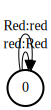

In [5]:
withscope() do scope
    fsttxt = asfile(scope, """
    0 0 red Red
    0 0 Red red
    """)
    syms = asfile(scope, make_syms_txt(split("red Red")))
    
    fst = asfile(scope, readstring(fstcompile(syms, fsttxt))) 
    run(`fstinfo $fst`) # Here we don't need to capture the output, it can just be printed to STDOUT 
    draw_fst(fst)
end;
    

Now a more complicted example.
We are going to generate a lexicon (dictionary), FST that tranduces between a part of speech, and a word that matches it.
And a Finite State Acceptor (FSA) that defines a grammer on parts of speech -- a legal ordering of those parts of speech.
We would like to find out what are the legal orderings of words from that lexicon.
We do this by composing the FSA with the FST,
then projecting to only the output space (the words from the lexicon).
The code uses a few more `asfile`s than I would like, it maybe be possible to pipe the input the the `fstcompile` so that can go straight from a string of the text FST table, to the compiled FST.
overall thought it is fairly clean and I think one can easily see what is going on.

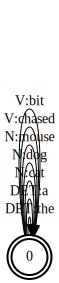

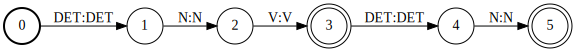

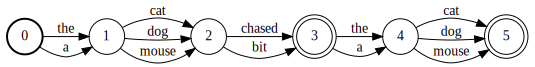

In [6]:
withscope() do scope
    syms = asfile(scope, make_syms_txt(split("DET N V the a cat dog mouse chased bit")))
    dictFst = asfile(scope, readstring(fstcompile(syms, asfile(scope, """
    0 0 DET the
    0 0 DET a
    0 0 N cat
    0 0 N dog
    0 0 N mouse
    0 0 V chased
    0 0 V bit
    0
    """))))
    draw_fst(dictFst)
    
    grammarFsa = asfile(scope, readstring(fstcompile(`--acceptor`, syms, asfile(scope, """
    0 1 DET
    1 2 N
    2 3 V
    3 4 DET
    4 5 N
    5
    3
    """))))
    draw_fst(grammarFsa)
    
    img = pipeline(
        `fstcompose --fst_compat_symbols=false $grammarFsa $dictFst`,
        `fstproject --project_output`,
        `fstdraw --portrait --acceptor`,
        `dot -Tsvg`
    ) |> readstring     
    display("image/svg+xml", img)
end;


So there you have it. Julia as a glue language.
Sticking together commandline scripts as well as any shell language.
But it is no turing tarpit -- it is one of the most expessive programming languages around.
So next time you find yourself bashing tools together (pun intended), maybe use julia.
I wouldn't say it is worth learning just for that, but if it is aleady part of your repertoire,
then I wouldn't be wasting my time with bash, for orchestrating these kinda of workflows.
Especially once julia 1.0 (or 2.0) comes out and everything becomes stable.
